### word2vecの高速化
* Embeddingレイヤの導入
* Negative Samplingという新しい損失関数の導入。

##### 問題点
* 入力層がone-hot表現のため語彙数が増えるとそれ相応のメモリサイズが必要になる。→Embedding層の追加
* 中間層の問題（多くの計算が必要になる）→Negative sampling 

#### Embeddingレイヤ
* 単語IDに該当する行を抜き出すレイヤ(**Embedding層**)
* 単語の密なベクトル表現を単語の埋め込み（Embedding）や単語の分散表現と呼ばれる。

#### 中間層の問題
* 多値分類から二値分類に変換する。（これはAであるか否かみたいな感じ）

##### シグモイド関数と交差エントロピー誤差
* 多値分類の場合は出力層にはソフトマックス関数、損失関数には交差エントロピー誤差
* 二値分類の出力層にはシグモイド関数、損失関数には交差エントロピー誤差

$$L=-(t\log{y}+(1-t)\log{(1-y)})$$

In [1]:
import numpy as np
import os

In [2]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]#特定の行を抜き出す
        return out 
    
#     def backward(self, dout):
#         dW, = self.grads
#         dW[...] = 0
#         dW[self.idx] = dout
#         return None

#重複問題が発生するため、代入ではなく加算を行う。
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)#Numpyの方が早い
        
        return None

In [3]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

#### Negative Sampling

* 一部だけ取ってくる
* コーパスから各単語の出現回数を求め、確率分布で表現する。（その確率分布から単語をサンプリングする）

In [4]:
print(np.random.choice(10))
words = ["you", "say", "goodbye", "I", "hello", "."]
print(np.random.choice(words))
print(np.random.choice(words, size=5))
print(np.random.choice(words, size=5, replace=False))
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
print(np.random.choice(words, p=p))

3
you
['say' 'hello' '.' 'I' 'you']
['goodbye' '.' 'hello' 'say' 'I']
.


* 次のようにすることで少しだけ確率が上がる

$$P^{'}(w_i)=\frac{P(w_i)^{0.75}}{\sum_j^{n}P(w_j)^{0.75}}$$

In [5]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [6]:
os.chdir("/work/NaturalProcessing/deep-learning-from-scratch-2-master/")
corpus = np.array([0, 1 ,2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

from ch04.negative_sampling_layer import UnigramSampler
sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[2 3]
 [4 1]
 [4 2]]


In [7]:
from common.layers import SigmoidWithLoss
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layer = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layer[0].forward(score, correct_label)
        
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layer[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layer, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
            
        return dh

In [8]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype("f")
        W_out = 0.01 * np.random.randn(V, H).astype("f")
        
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backword(self, dout=1):
        dout = self.ns_loss.backword(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backword(dout)
        return None

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 1[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 3[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 4[s] | loss 4.13
| epoch 1 |  iter 81 / 9295 | time 6[s] | loss 4.06
| epoch 1 |  iter 101 / 9295 | time 7[s] | loss 3.94
| epoch 1 |  iter 121 / 9295 | time 9[s] | loss 3.79
| epoch 1 |  iter 141 / 9295 | time 10[s] | loss 3.63
| epoch 1 |  iter 161 / 9295 | time 11[s] | loss 3.48
| epoch 1 |  iter 181 / 9295 | time 13[s] | loss 3.34
| epoch 1 |  iter 201 / 9295 | time 14[s] | loss 3.25
| epoch 1 |  iter 221 / 9295 | time 16[s] | loss 3.16
| epoch 1 |  iter 241 / 9295 | time 18[s] | loss 3.10
| epoch 1 |  iter 261 / 9295 | time 19[s] | loss 3.02
| epoch 1 |  iter 281 / 9295 | time 21[s] | loss 2.95
| epoch 1 |  iter 301 / 9295 | time 22[s] | loss 2.92
| epoch 1 |  iter 321 / 9295 | time 24[s] | loss 2.87
| epoch 1 |  iter 341 / 9295 | time 25[s] | loss 2.85
| epoch 1 |  iter 361 / 9295 | time 27[s]

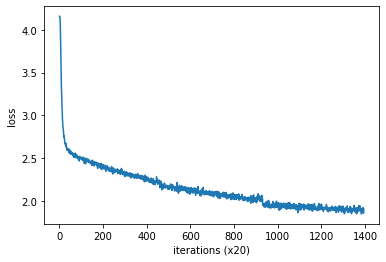

In [9]:
from common import config
# GPUで実行する場合は、下記のコメントアウトを消去（要cupy）
# ===============================================
# config.GPU = True
# ===============================================
from common.np import *
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from ch04.skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 3

# データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


In [10]:
from common.util import most_similar, analogy
import pickle


pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# most similar task
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# analogy task
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[query] you
 we: 0.89990234375
 i: 0.89208984375
 why: 0.8662109375
 else: 0.8447265625
 really: 0.83447265625

[query] year
 month: 0.94189453125
 summer: 0.86669921875
 week: 0.8662109375
 spring: 0.8232421875
 decade: 0.6748046875

[query] car
 truck: 0.79541015625
 supercomputer: 0.77734375
 portable: 0.77392578125
 cap: 0.75927734375
 machine: 0.75634765625

[query] toyota
 weyerhaeuser: 0.8603515625
 hewlett-packard: 0.84912109375
 packaging: 0.84619140625
 alberta: 0.841796875
 occidental: 0.841796875
--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.2578125
 veto: 4.9375
 thing: 4.90234375
 wife: 4.6171875
 know: 4.421875

[analogy] take:took = go:?
 was: 3.837890625
 're: 3.724609375
 years: 3.564453125
 a.m: 3.48046875
 seems: 3.37890625

[analogy] car:cars = child:?
 a.m: 6.11328125
 daffynition: 4.58984375
 i: 4.390625
 rape: 4.2109375
 years: 3.9921875

[analogy] good:better = bad:?
 more: 4.99609375
 less: 4.2421875
 than: 4.07421

### 転移学習
* 自然言語処理のタスクの際はゼロから単語の分散表現で学習することはない。
* 先に大きなコーパスで学習を行い、その学習済みの分散表現を個別のタスクで利用する。
